In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import ast
from PIL import Image
!jupyter kernelspec list

Available kernels:
  rl         /home/shivani/.local/share/jupyter/kernels/rl
  python3    /home/shivani/anaconda3/share/jupyter/kernels/python3


In [4]:
def get_data(num_training=100000, num_validation=10000, num_test=10000):
    data_dir = '/home/bair/Pictures/'
    y_file = data_dir + 'coords.txt'
    Y = [ast.literal_eval(line.rstrip('\n')) for line in open(y_file)]
    Y = np.asarray(Y)
    X = [np.array(Image.open(data_dir + 'train%d.png' %i)) for i in range(100000)]
    X = np.array(X)
    
    X_train = X[0:num_training]
    Y_train = Y[0:num_training]

    X_val = X[num_training: num_training + num_validation]
    Y_val = Y[num_training: num_training + num_validation]

    X_test = X[-num_test : ]
    Y_test = Y[-num_test : ]


    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [243]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_data()

In [1]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', Y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', Y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

NameError: name 'X_train' is not defined

[1.43121379 0.69261001 1.34684102 0.63567464]
[1.24228929 0.61723896 1.29610551 0.73432107]
[1.38689067 0.8886655  1.31247949 0.82813767]
[1.2939186  0.63965278 1.3212541  0.77418283]
[1.26063312 0.87936203 1.22656731 0.72988413]
[1.21483109 0.69344188 1.46432205 0.71479713]
[1.3392386  0.62435915 1.40463345 0.8782232 ]
[1.23788167 0.64684577 1.25443543 0.80424693]
[1.31089311 0.84464571 1.32826512 0.75550059]
[1.45227029 0.67180364 1.25310992 0.78878652]


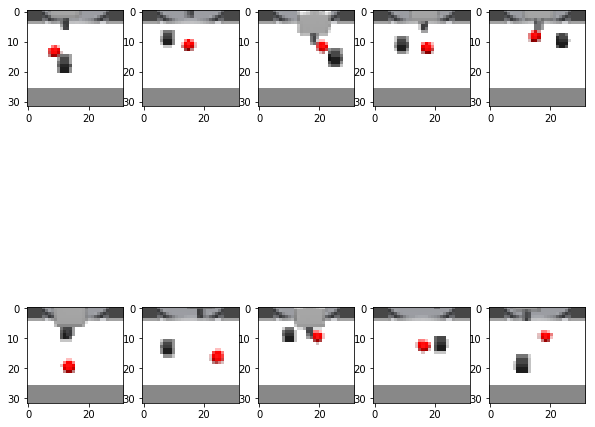

In [245]:
#Visualize some examples from the dataset.
f = plt.figure(figsize=(10,10))
for y in range(1, 11):
    plt.subplot(2, 5, y)
    plt.imshow(X_train[y].astype('uint8'))
    print(Y_train[y])
plt.show()

In [246]:
def model(X,y,is_training, beta):
    
    # Setup Vars
    Wconv = tf.get_variable("Wconv", shape=[7, 7, 3, 32])
    bconv = tf.get_variable("bconv", shape=[32])
    sconv = tf.get_variable("sc", shape=[26, 26, 32]) # bn scale param
    oconv = tf.get_variable("oc", shape=[26, 26, 32]) # bn offset param
    W1 = tf.get_variable("W1", shape=[26*26*32//4, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    s1 = tf.get_variable("s1", shape=[1024])
    o1 = tf.get_variable("o1", shape=[1024])
    W2 = tf.get_variable("W2", shape=[1024, 4])
    b2 = tf.get_variable("b2", shape=[4])
    
    # Setup Graph
    # conv
    a1 = tf.nn.conv2d(X, Wconv, strides=[1,1,1,1], padding='VALID') + bconv
    # bn_conv
    mc1, vc1 = tf.nn.moments(a1, axes=[0], keep_dims=False)
    a2 = tf.nn.batch_normalization(a1, mc1, vc1, oconv, sconv, 1e-6)
    # relu
    a3 = tf.nn.relu(a2)
    # pool
    a4 = tf.nn.max_pool(a3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', data_format='NHWC')
    # affine 1
    a5 = tf.reshape(a4, [-1, 26*26*32//4])
    a6 = tf.matmul(a5, W1) + b1
    # bn1
    m1, v1 = tf.nn.moments(a6, axes=[0], keep_dims=False)
    a7 = tf.nn.batch_normalization(a6, m1, v1, o1, s1, 1e-6)
    # affine 2
    a8 = tf.nn.bias_add(tf.matmul(a7, W2), b2, name='y_out')
    y_out = a8
    reg = tf.nn.l2_loss(Wconv)
    reg += tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    reg *= beta
    
    return y_out, reg

In [255]:
#to save model
params = {}
#clear old variables
tf.reset_default_graph()

#input
X = tf.placeholder(tf.float32, [None, 32, 32, 3], name='X')
y = tf.placeholder(tf.float32, [None, 4], name='y')
is_training = tf.placeholder(tf.bool, name='is_training')

mean_image = tf.reduce_mean(X_train, axis= 0)
mean_image = tf.reshape(mean_image, [1, 32, 32, 3])
mean_image = tf.dtypes.cast(mean_image,dtype = tf.float32)
X -= mean_image

beta = tf.placeholder(tf.float32, name='beta')
global_step = tf.Variable(0, trainable=False, name='global_step')
starting_learning_rate = 1e-3

#with tf.name_scope('scope1'):
y_out, reg = model(X,y,is_training,beta)

mean_loss = tf.reduce_mean(tf.losses.mean_squared_error(y, y_out), name = 'mean_loss') + reg
learning_rate = tf.train.exponential_decay(starting_learning_rate, global_step,100, decay_rate= 0.95, staircase=True)

optimizer = tf.train.AdamOptimizer(starting_learning_rate)
train_step = optimizer.minimize(mean_loss) #,global_step=global_step)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [256]:
#sess,y_out,mean_loss,X_train,y_train,5,64,100,train_step,True,regbeta=1e-3
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=True, regbeta= 1.0):
#     with tf.name_scope("my_scope"):
        # have tensorflow compute accuracy
    correct_prediction = tf.math.less(tf.abs(y - predict), tf.constant(0.05), name='num')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        if training_now:
            file.write("\nEpoch :%d \n"%e)
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))): # TODO: ceil?? Is this right?!
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now,
                         global_step: iter_cnt,
                         beta: regbeta
                        }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1

        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.6g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('Minibatch number')
            plt.ylabel('Minibatch loss')
            plt.show()


    return total_loss,total_correct

Training
Iteration 0: with minibatch training loss = 2.83 and accuracy of 0
Iteration 100: with minibatch training loss = 0.00945 and accuracy of 3.6
Iteration 200: with minibatch training loss = 0.00814 and accuracy of 3.8
Iteration 300: with minibatch training loss = 0.00758 and accuracy of 3.8
Epoch 1, Overall loss = 0.084 and accuracy of 3.26124


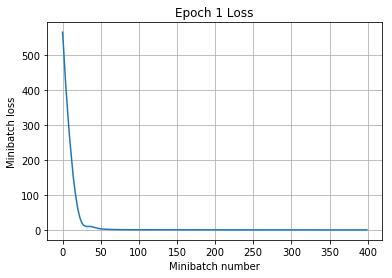

Iteration 400: with minibatch training loss = 0.00706 and accuracy of 3.9
Iteration 500: with minibatch training loss = 0.00709 and accuracy of 3.8
Iteration 600: with minibatch training loss = 0.00667 and accuracy of 3.9
Iteration 700: with minibatch training loss = 0.00644 and accuracy of 3.9
Epoch 2, Overall loss = 0.00676 and accuracy of 3.86446


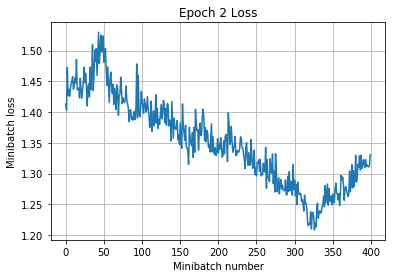

Iteration 800: with minibatch training loss = 0.00658 and accuracy of 3.9
Iteration 900: with minibatch training loss = 0.00657 and accuracy of 3.9
Iteration 1000: with minibatch training loss = 0.00602 and accuracy of 3.9
Iteration 1100: with minibatch training loss = 0.00603 and accuracy of 3.9
Epoch 3, Overall loss = 0.00619 and accuracy of 3.89158


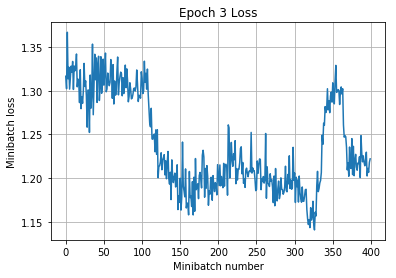

Iteration 1200: with minibatch training loss = 0.00603 and accuracy of 3.9
Iteration 1300: with minibatch training loss = 0.00622 and accuracy of 3.9
Iteration 1400: with minibatch training loss = 0.00544 and accuracy of 3.9
Iteration 1500: with minibatch training loss = 0.00523 and accuracy of 3.9
Epoch 4, Overall loss = 0.00551 and accuracy of 3.90791


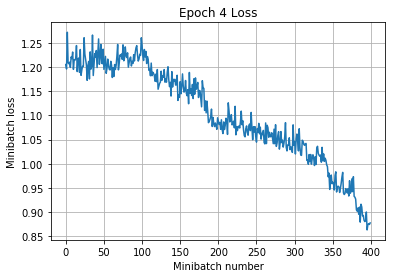

Iteration 1600: with minibatch training loss = 0.00431 and accuracy of 3.9
Iteration 1700: with minibatch training loss = 0.00462 and accuracy of 3.9
Iteration 1800: with minibatch training loss = 0.00529 and accuracy of 3.9
Iteration 1900: with minibatch training loss = 0.00554 and accuracy of 4
Epoch 5, Overall loss = 0.00527 and accuracy of 3.9172


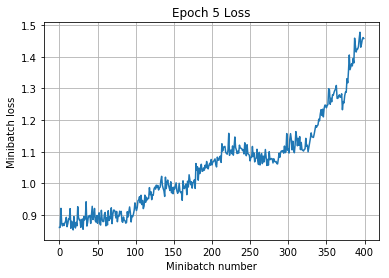

Iteration 2000: with minibatch training loss = 0.00723 and accuracy of 3.9
Iteration 2100: with minibatch training loss = 0.00826 and accuracy of 3.9
Iteration 2200: with minibatch training loss = 0.00733 and accuracy of 3.9
Iteration 2300: with minibatch training loss = 0.00718 and accuracy of 4
Epoch 6, Overall loss = 0.00755 and accuracy of 3.9213


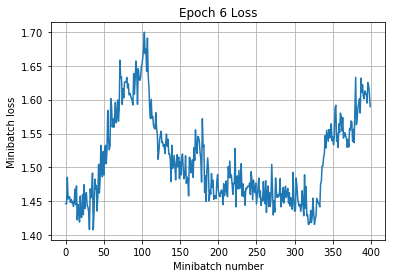

Iteration 2400: with minibatch training loss = 0.00803 and accuracy of 3.9
Iteration 2500: with minibatch training loss = 0.00699 and accuracy of 3.9
Iteration 2600: with minibatch training loss = 0.00704 and accuracy of 3.9
Iteration 2700: with minibatch training loss = 0.00684 and accuracy of 4
Epoch 7, Overall loss = 0.00713 and accuracy of 3.92707


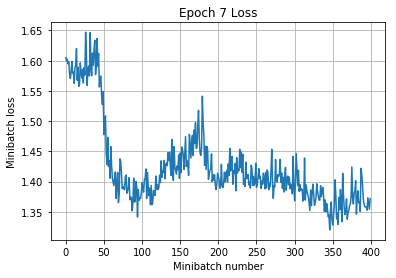

Iteration 2800: with minibatch training loss = 0.00695 and accuracy of 3.9
Iteration 2900: with minibatch training loss = 0.0072 and accuracy of 3.9
Iteration 3000: with minibatch training loss = 0.00726 and accuracy of 3.9
Iteration 3100: with minibatch training loss = 0.00696 and accuracy of 4
Epoch 8, Overall loss = 0.00714 and accuracy of 3.92738


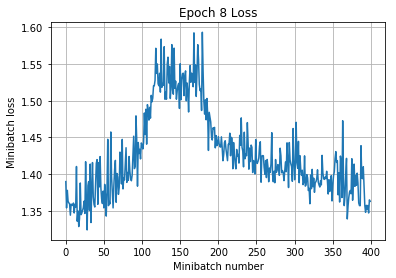

Iteration 3200: with minibatch training loss = 0.0068 and accuracy of 4
Iteration 3300: with minibatch training loss = 0.007 and accuracy of 3.9
Iteration 3400: with minibatch training loss = 0.00741 and accuracy of 3.9
Iteration 3500: with minibatch training loss = 0.00746 and accuracy of 4
Epoch 9, Overall loss = 0.00735 and accuracy of 3.92397


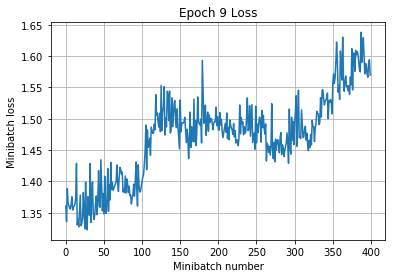

Iteration 3600: with minibatch training loss = 0.00785 and accuracy of 4
Iteration 3700: with minibatch training loss = 0.00855 and accuracy of 3.9
Iteration 3800: with minibatch training loss = 0.00857 and accuracy of 4
Iteration 3900: with minibatch training loss = 0.00905 and accuracy of 4
Epoch 10, Overall loss = 0.00858 and accuracy of 3.92627


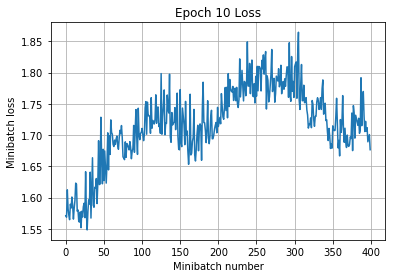

(0.00858459882088937, 3.926275)

In [260]:
file = open("Params.txt","w+")
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Training')

run_model(sess,y_out,mean_loss,X_train,Y_train,10,200,100,train_step, True, regbeta=1e-3)
# print('Validation')
# run_model(sess,y_out,mean_loss,X_val,Y_val,1,200)
# file.close()

Validation
Epoch 1, Overall loss = 8.02 and accuracy of 3.9415


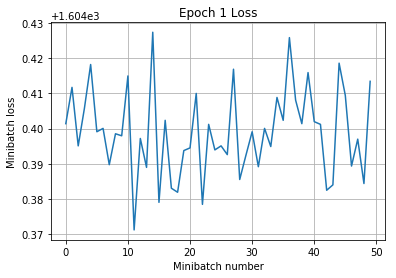

In [261]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,Y_val,1,200)
file.close()

In [262]:
saver = tf.train.Saver() 
saver.save(sess, 'cnn-model')

'cnn-model'

Epoch 1, Overall loss = 8.02 and accuracy of 3.9063


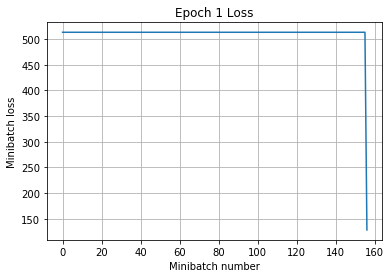

(8.022129820251465, 3.9063)

In [263]:
run_model(sess,y_out,mean_loss,X_test,Y_test,1,64)